# Análise de Performance do Servidor Online Boutique

Este notebook analisa a performance do servidor durante um teste de carga de 10 segundos com 200 usuários simultâneos.

## Métricas Analisadas:
- **Latência**: Tempo de resposta das requisições
- **Throughput**: Requisições por segundo
- **Uso de CPU**: Consumo de recursos do servidor
- **Escalabilidade**: Máximo de réplicas do HPA (Horizontal Pod Autoscaler)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuração do estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Carregamento dos Dados


In [ ]:
# Carregar dados do Locust
locust_stats = pd.read_csv('load-testing/results/monolith_run_stats.csv')
locust_history = pd.read_csv('load-testing/results/monolith_run_stats_history.csv')

# Carregar dados de métricas do servidor
hpa_max = pd.read_csv('monolith/hpa_max.csv')
hpa_current = pd.read_csv('monolith/hpa_current.csv')
hpa_desired = pd.read_csv('monolith/hpa_desired.csv')
cpu_pod = pd.read_csv('monolith/cpu_pod_long.csv')

print("Dados carregados com sucesso!")
print(f"Locust Stats: {len(locust_stats)} linhas")
print(f"Locust History: {len(locust_history)} linhas")
print(f"HPA Max: {len(hpa_max)} linhas")
print(f"HPA Current: {len(hpa_current)} linhas")
print(f"HPA Desired: {len(hpa_desired)} linhas")
print(f"CPU Pod: {len(cpu_pod)} linhas")


Dados carregados com sucesso!
Locust Stats: 12 linhas
Locust History: 296 linhas
HPA Max: 22 linhas
HPA Current: 22 linhas
HPA Desired: 22 linhas
CPU Pod: 22 linhas


## 2. Análise de Latência


=== MÉTRICAS DE LATÊNCIA ===
      Métrica  Tempo (ms)
Mediana (50%)   11.000000
        Média   13.686326
          P95   23.000000
          P99  100.000000
       Máximo  239.105800


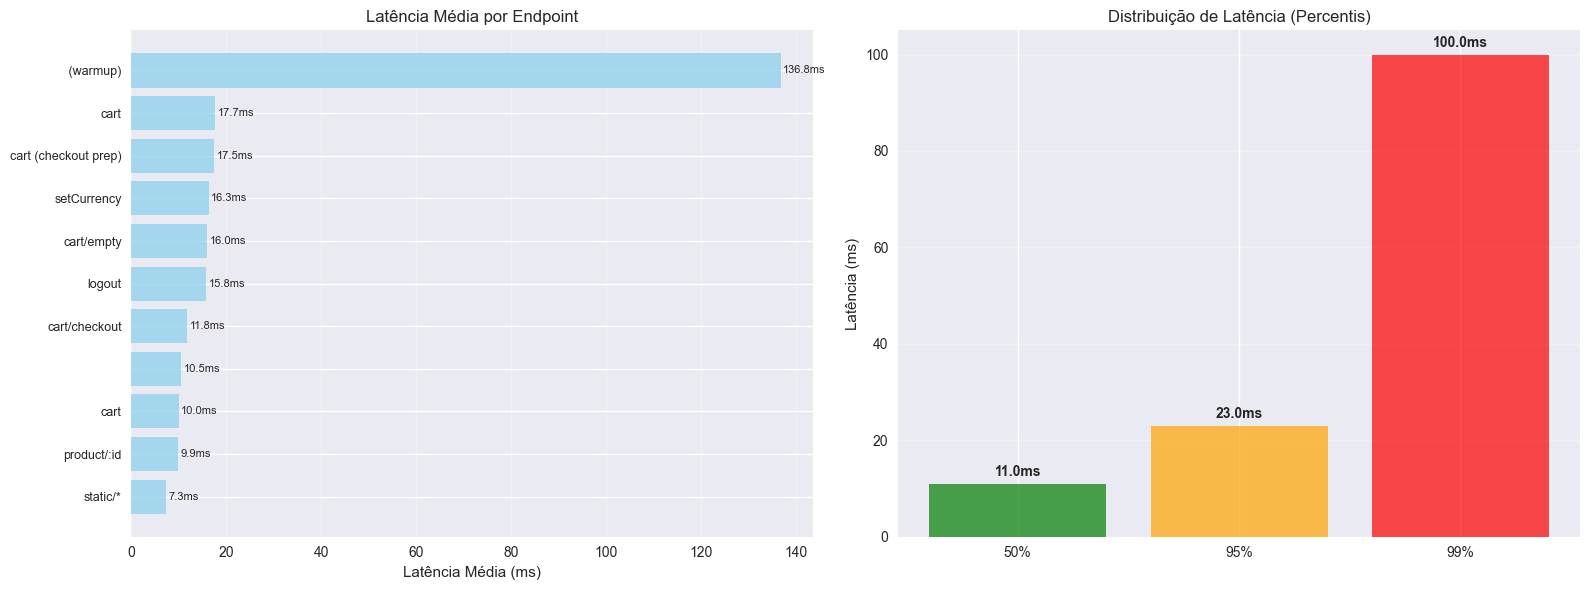

In [11]:
# Filtrar apenas dados agregados do Locust
aggregated_stats = locust_stats[locust_stats['Type'].isna() | (locust_stats['Type'] == '')]

# Extrair métricas de latência
latency_metrics = {
    'Métrica': ['Mediana (50%)', 'Média', 'P95', 'P99', 'Máximo'],
    'Tempo (ms)': [
        aggregated_stats['Median Response Time'].iloc[0],
        aggregated_stats['Average Response Time'].iloc[0],
        aggregated_stats['95%'].iloc[0],
        aggregated_stats['99%'].iloc[0],
        aggregated_stats['Max Response Time'].iloc[0]
    ]
}

latency_df = pd.DataFrame(latency_metrics)
print("=== MÉTRICAS DE LATÊNCIA ===")
print(latency_df.to_string(index=False))

# Gráfico de latência por endpoint
endpoint_stats = locust_stats[locust_stats['Type'].notna() & (locust_stats['Type'] != '')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Latência média por endpoint
endpoint_latency = endpoint_stats.groupby('Name')['Average Response Time'].mean().sort_values(ascending=True)
bars1 = ax1.barh(range(len(endpoint_latency)), endpoint_latency.values, color='skyblue', alpha=0.7)
ax1.set_yticks(range(len(endpoint_latency)))
ax1.set_yticklabels([name.replace('GET /', '').replace('POST /', '') for name in endpoint_latency.index], fontsize=9)
ax1.set_xlabel('Latência Média (ms)')
ax1.set_title('Latência Média por Endpoint')
ax1.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}ms', 
             ha='left', va='center', fontsize=8)

# Gráfico 2: Distribuição de latência (P50, P95, P99)
percentiles = ['50%', '95%', '99%']
percentile_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]

bars2 = ax2.bar(percentiles, percentile_values, color=['green', 'orange', 'red'], alpha=0.7)
ax2.set_ylabel('Latência (ms)')
ax2.set_title('Distribuição de Latência (Percentis)')
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, percentile_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Análise de Throughput


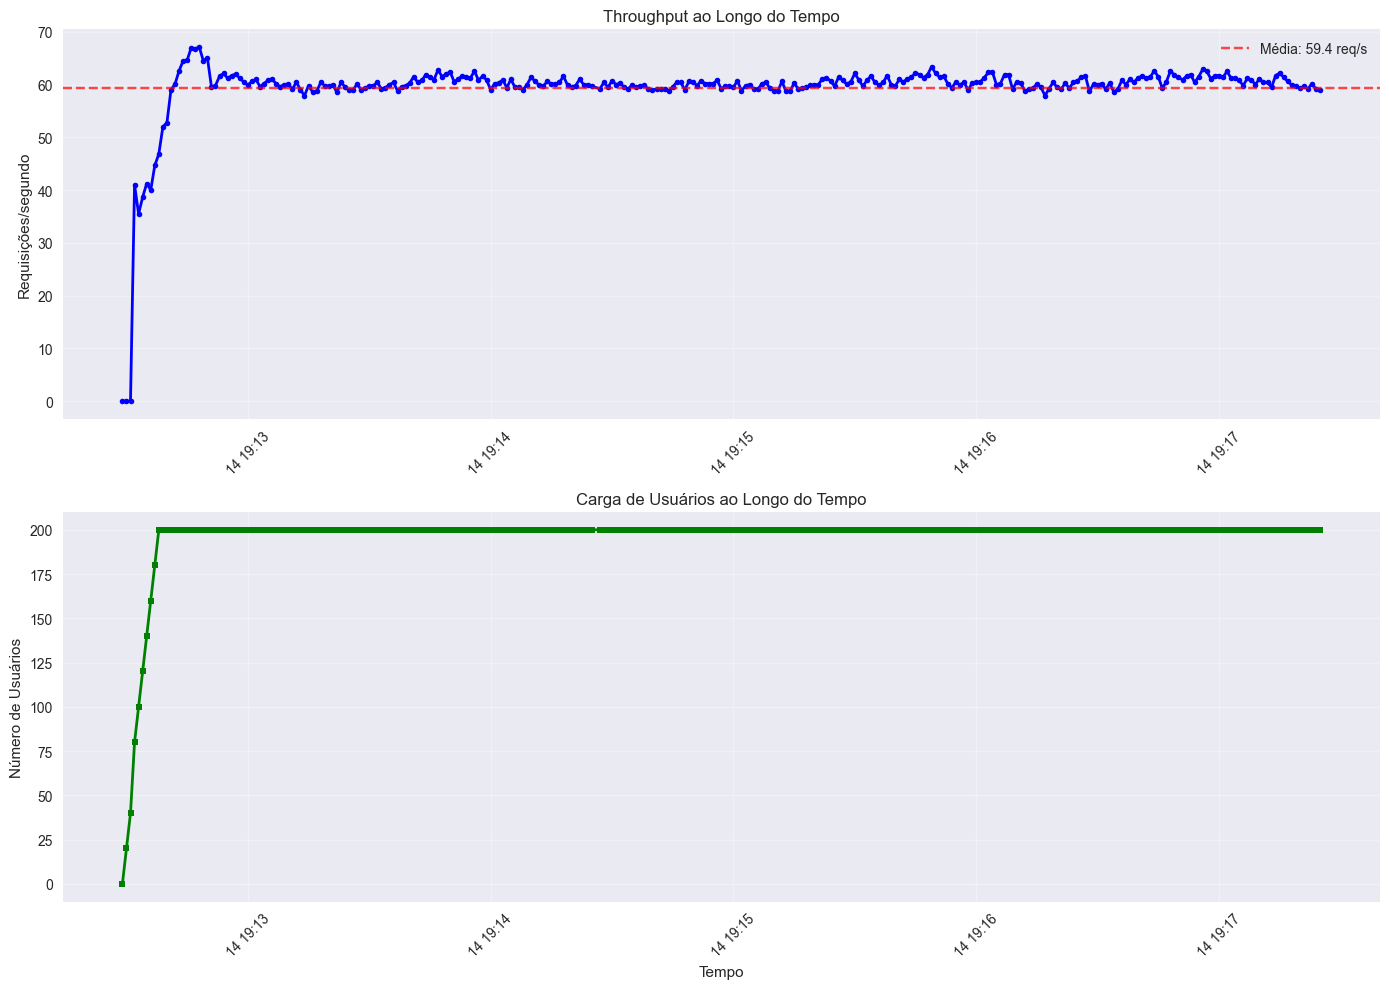

=== ESTATÍSTICAS DE THROUGHPUT ===
Throughput Médio: 59.35 req/s
Throughput Máximo: 67.10 req/s
Throughput Mínimo: 0.00 req/s
Desvio Padrão: 6.87 req/s


In [12]:
# Converter timestamp para datetime
locust_history['datetime'] = pd.to_datetime(locust_history['Timestamp'], unit='s')
hpa_max['datetime'] = pd.to_datetime(hpa_max['timestamp'], unit='s')
hpa_current['datetime'] = pd.to_datetime(hpa_current['timestamp'], unit='s')
hpa_desired['datetime'] = pd.to_datetime(hpa_desired['timestamp'], unit='s')
cpu_pod['datetime'] = pd.to_datetime(cpu_pod['timestamp'], unit='s')

# Filtrar apenas dados agregados do histórico
history_aggregated = locust_history[locust_history['Type'].isna() | (locust_history['Type'] == '')]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Throughput ao longo do tempo
ax1.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', marker='o', markersize=4)
ax1.set_ylabel('Requisições/segundo')
ax1.set_title('Throughput ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de média
avg_throughput = history_aggregated['Requests/s'].mean()
ax1.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_throughput:.1f} req/s')
ax1.legend()

# Gráfico 2: Número de usuários ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['User Count'], 
         linewidth=2, color='green', marker='s', markersize=4)
ax2.set_ylabel('Número de Usuários')
ax2.set_xlabel('Tempo')
ax2.set_title('Carga de Usuários ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas de throughput
print("=== ESTATÍSTICAS DE THROUGHPUT ===")
print(f"Throughput Médio: {avg_throughput:.2f} req/s")
print(f"Throughput Máximo: {history_aggregated['Requests/s'].max():.2f} req/s")
print(f"Throughput Mínimo: {history_aggregated['Requests/s'].min():.2f} req/s")
print(f"Desvio Padrão: {history_aggregated['Requests/s'].std():.2f} req/s")


## 4. Análise de Uso de CPU


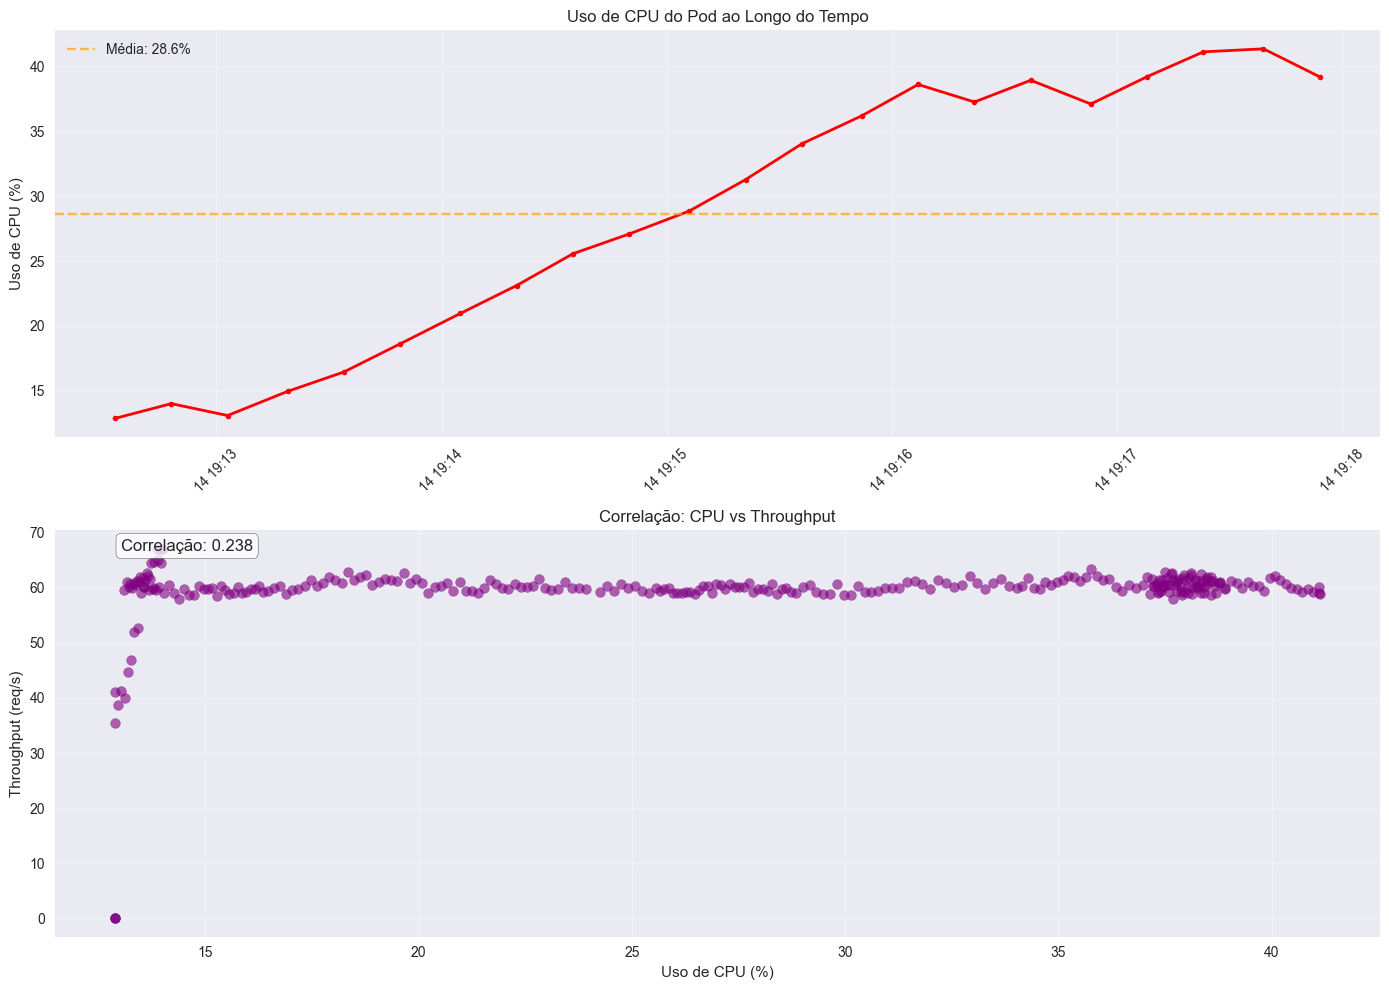

=== ESTATÍSTICAS DE CPU ===
CPU Médio: 28.62%
CPU Máximo: 41.33%
CPU Mínimo: 12.88%
Desvio Padrão: 10.29%
Correlação CPU-Throughput: 0.238


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Uso de CPU ao longo do tempo
ax1.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', marker='o', markersize=4)
ax1.set_ylabel('Uso de CPU (%)')
ax1.set_title('Uso de CPU do Pod ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de média
avg_cpu = cpu_pod['cores'].mean() * 100
ax1.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_cpu:.1f}%')
ax1.legend()

# Gráfico 2: Correlação entre CPU e Throughput
# Interpolar dados para alinhar timestamps
cpu_interp = np.interp(history_aggregated['Timestamp'], 
                      cpu_pod['timestamp'], 
                      cpu_pod['cores'] * 100)

ax2.scatter(cpu_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='purple')
ax2.set_xlabel('Uso de CPU (%)')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correlação: CPU vs Throughput')
ax2.grid(True, alpha=0.3)

# Calcular correlação
correlation = np.corrcoef(cpu_interp, history_aggregated['Requests/s'])[0, 1]
ax2.text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
         transform=ax2.transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estatísticas de CPU
print("=== ESTATÍSTICAS DE CPU ===")
print(f"CPU Médio: {avg_cpu:.2f}%")
print(f"CPU Máximo: {cpu_pod['cores'].max() * 100:.2f}%")
print(f"CPU Mínimo: {cpu_pod['cores'].min() * 100:.2f}%")
print(f"Desvio Padrão: {cpu_pod['cores'].std() * 100:.2f}%")
print(f"Correlação CPU-Throughput: {correlation:.3f}")


## 5. Análise de Escalabilidade (HPA) - Current, Desired e Max Réplicas

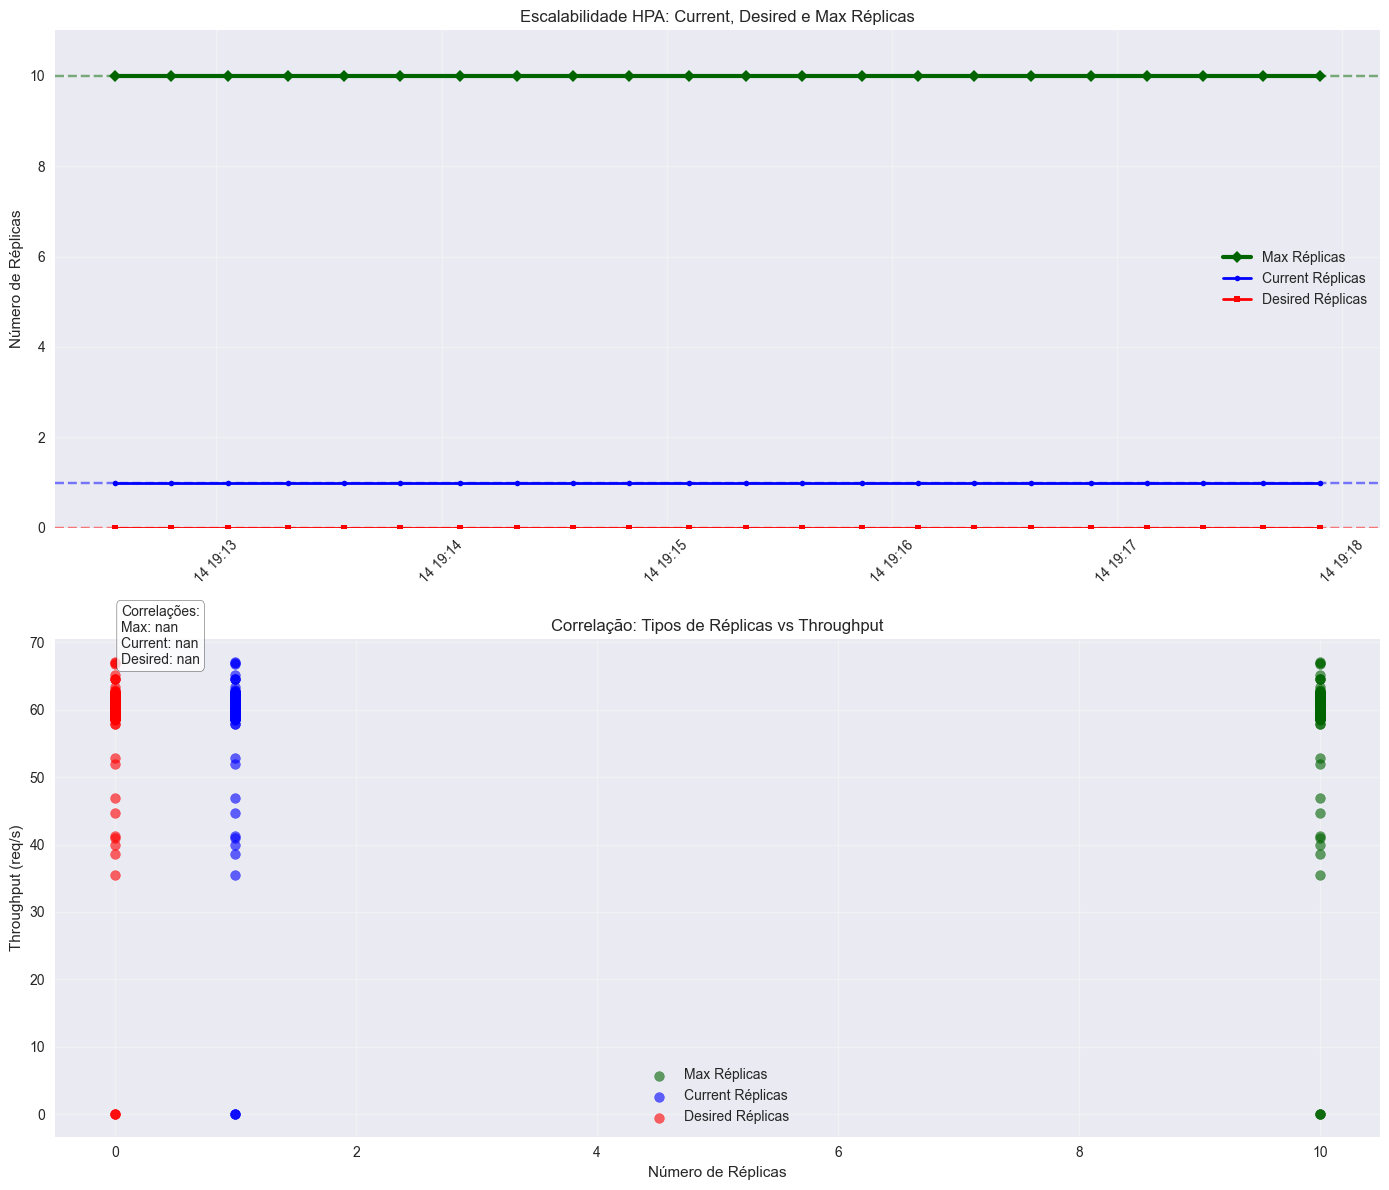

=== ESTATÍSTICAS DE ESCALABILIDADE ===
Max Réplicas - Médio: 10.0, Máximo: 10, Mínimo: 10
Current Réplicas - Médio: 1.0, Máximo: 1, Mínimo: 1
Desired Réplicas - Médio: 0.0, Máximo: 0, Mínimo: 0

Correlações com Throughput:
  • Max Réplicas: nan
  • Current Réplicas: nan
  • Desired Réplicas: nan


In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Gráfico 1: Todas as métricas de réplicas do HPA ao longo do tempo
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max Réplicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current Réplicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired Réplicas')

ax1.set_ylabel('Número de Réplicas')
ax1.set_title('Escalabilidade HPA: Current, Desired e Max Réplicas')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

# Adicionar linhas de média
avg_max = hpa_max['max_replicas'].mean()
avg_current = hpa_current['current_replicas'].mean()
avg_desired = hpa_desired['desired_replicas'].mean()

ax1.axhline(y=avg_max, color='darkgreen', linestyle='--', alpha=0.5, 
           label=f'Max Médio: {avg_max:.1f}')
ax1.axhline(y=avg_current, color='blue', linestyle='--', alpha=0.5, 
           label=f'Current Médio: {avg_current:.1f}')
ax1.axhline(y=avg_desired, color='red', linestyle='--', alpha=0.5, 
           label=f'Desired Médio: {avg_desired:.1f}')

# Gráfico 2: Correlação entre diferentes tipos de réplicas e throughput
# Interpolar dados para alinhar timestamps
max_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                               hpa_max['timestamp'], 
                               hpa_max['max_replicas'])
current_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_current['timestamp'], 
                                   hpa_current['current_replicas'])
desired_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_desired['timestamp'], 
                                   hpa_desired['desired_replicas'])

# Scatter plot com diferentes cores para cada tipo
ax2.scatter(max_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='darkgreen', label='Max Réplicas')
ax2.scatter(current_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='blue', label='Current Réplicas')
ax2.scatter(desired_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='red', label='Desired Réplicas')

ax2.set_xlabel('Número de Réplicas')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correlação: Tipos de Réplicas vs Throughput')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calcular correlações
correlation_max = np.corrcoef(max_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_current = np.corrcoef(current_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_desired = np.corrcoef(desired_replicas_interp, history_aggregated['Requests/s'])[0, 1]

ax2.text(0.05, 0.95, f'Correlações:\nMax: {correlation_max:.3f}\nCurrent: {correlation_current:.3f}\nDesired: {correlation_desired:.3f}', 
         transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estatísticas de escalabilidade
print("=== ESTATÍSTICAS DE ESCALABILIDADE ===")
print(f"Max Réplicas - Médio: {avg_max:.1f}, Máximo: {hpa_max['max_replicas'].max()}, Mínimo: {hpa_max['max_replicas'].min()}")
print(f"Current Réplicas - Médio: {avg_current:.1f}, Máximo: {hpa_current['current_replicas'].max()}, Mínimo: {hpa_current['current_replicas'].min()}")
print(f"Desired Réplicas - Médio: {avg_desired:.1f}, Máximo: {hpa_desired['desired_replicas'].max()}, Mínimo: {hpa_desired['desired_replicas'].min()}")
print()
print("Correlações com Throughput:")
print(f"  • Max Réplicas: {correlation_max:.3f}")
print(f"  • Current Réplicas: {correlation_current:.3f}")
print(f"  • Desired Réplicas: {correlation_desired:.3f}")


## 6. Análise Detalhada das Métricas HPA


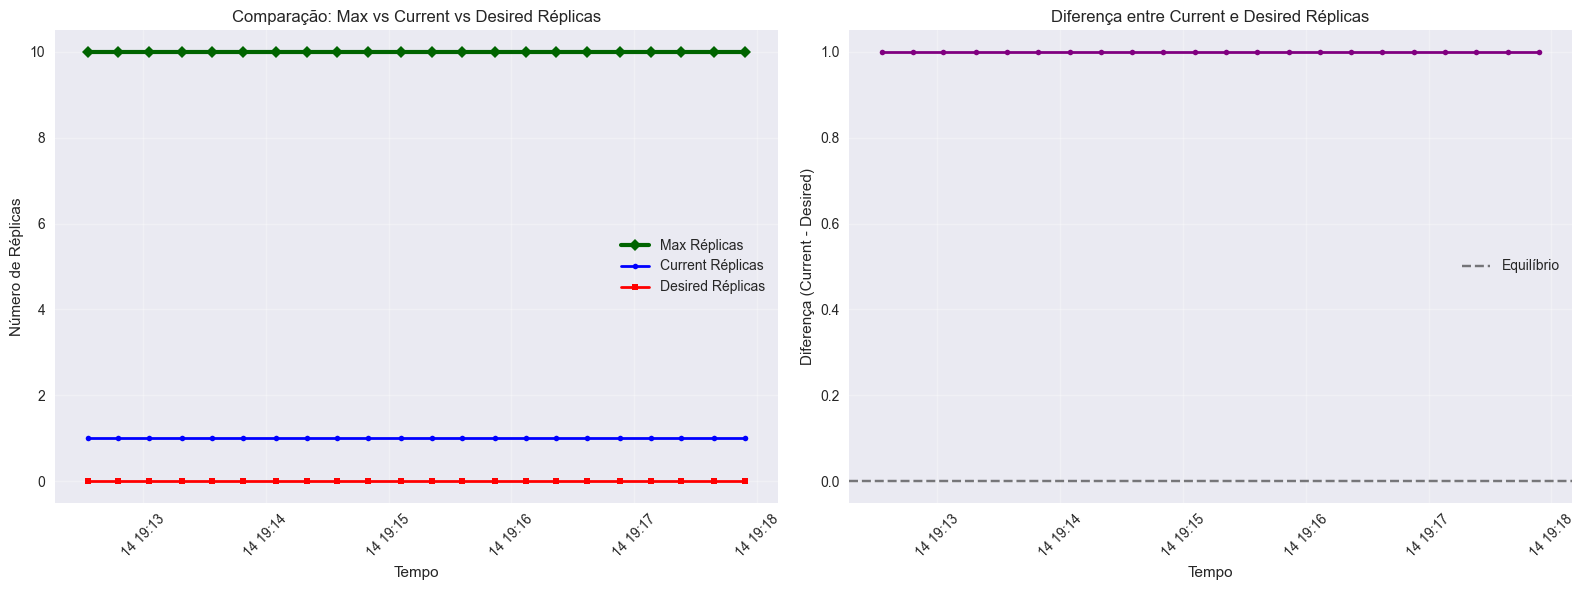

=== ANÁLISE DETALHADA DAS MÉTRICAS HPA ===
Max Réplicas: 10 (configuração do HPA)
Current Réplicas: 1 (réplicas ativas)
Desired Réplicas: 0 (réplicas desejadas pelo HPA)

Interpretação:
• O HPA está configurado mas não está escalando (desired = 0)
• Apenas 1 réplica está ativa (modo monolítico)
• O sistema não está sob pressão suficiente para escalar


## 7. Dashboard de Performance Completo


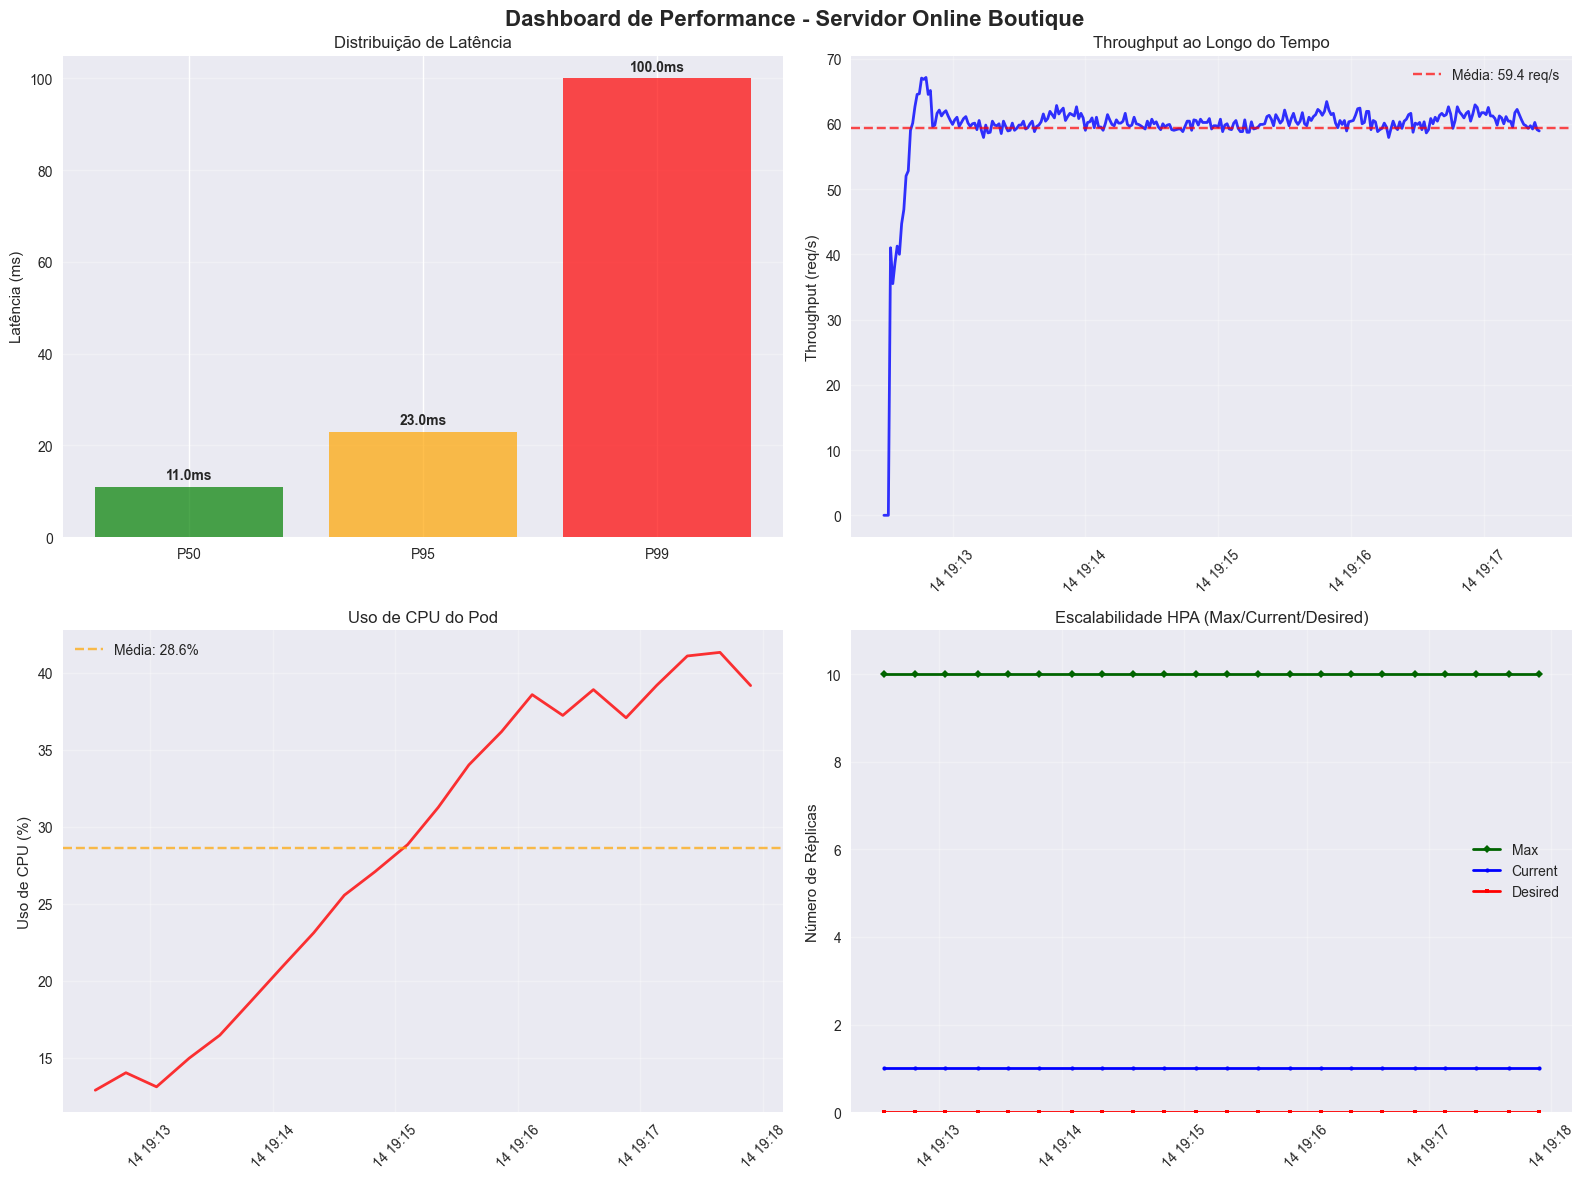

In [14]:
# Análise detalhada das métricas HPA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação das três métricas HPA
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max Réplicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current Réplicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired Réplicas')

ax1.set_ylabel('Número de Réplicas')
ax1.set_xlabel('Tempo')
ax1.set_title('Comparação: Max vs Current vs Desired Réplicas')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Diferença entre Current e Desired (indicador de escalabilidade ativa)
difference = hpa_current['current_replicas'] - hpa_desired['desired_replicas']
ax2.plot(hpa_current['datetime'], difference, 
         linewidth=2, color='purple', marker='o', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Equilíbrio')
ax2.set_ylabel('Diferença (Current - Desired)')
ax2.set_xlabel('Tempo')
ax2.set_title('Diferença entre Current e Desired Réplicas')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análise das métricas HPA
print("=== ANÁLISE DETALHADA DAS MÉTRICAS HPA ===")
print(f"Max Réplicas: {hpa_max['max_replicas'].iloc[0]} (configuração do HPA)")
print(f"Current Réplicas: {hpa_current['current_replicas'].iloc[0]} (réplicas ativas)")
print(f"Desired Réplicas: {hpa_desired['desired_replicas'].iloc[0]} (réplicas desejadas pelo HPA)")
print()
print("Interpretação:")
if hpa_current['current_replicas'].iloc[0] == 1 and hpa_desired['desired_replicas'].iloc[0] == 0:
    print("• O HPA está configurado mas não está escalando (desired = 0)")
    print("• Apenas 1 réplica está ativa (modo monolítico)")
    print("• O sistema não está sob pressão suficiente para escalar")
elif hpa_desired['desired_replicas'].iloc[0] > hpa_current['current_replicas'].iloc[0]:
    print("• O HPA está tentando escalar (desired > current)")
    print("• Réplicas adicionais estão sendo criadas")
elif hpa_desired['desired_replicas'].iloc[0] < hpa_current['current_replicas'].iloc[0]:
    print("• O HPA está tentando reduzir (desired < current)")
    print("• Réplicas estão sendo removidas")
else:
    print("• O HPA está em equilíbrio (desired = current)")
    print("• Número de réplicas está estável")

print()
print("=" * 60)
print()

# Dashboard completo
print("## 7. Dashboard de Performance Completo")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Latência por Percentil
percentiles = ['P50', 'P95', 'P99']
latency_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]
colors = ['green', 'orange', 'red']
bars1 = ax1.bar(percentiles, latency_values, color=colors, alpha=0.7)
ax1.set_ylabel('Latência (ms)')
ax1.set_title('Distribuição de Latência')
ax1.grid(axis='y', alpha=0.3)
for bar, value in zip(bars1, latency_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontweight='bold')

# 2. Throughput ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', alpha=0.8)
ax2.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_throughput:.1f} req/s')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Throughput ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# 3. Uso de CPU
ax3.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', alpha=0.8)
ax3.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_cpu:.1f}%')
ax3.set_ylabel('Uso de CPU (%)')
ax3.set_title('Uso de CPU do Pod')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. Escalabilidade (HPA) - Todas as métricas
ax4.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=2, color='darkgreen', marker='D', markersize=4, label='Max')
ax4.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=3, label='Current')
ax4.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=3, label='Desired')
ax4.set_ylabel('Número de Réplicas')
ax4.set_title('Escalabilidade HPA (Max/Current/Desired)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

plt.suptitle('Dashboard de Performance - Servidor Online Boutique', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 8. Resumo Executivo


In [15]:
# Criar resumo executivo
print("=" * 60)
print("           RESUMO EXECUTIVO DE PERFORMANCE")
print("=" * 60)
print()

print("📊 MÉTRICAS DE LATÊNCIA:")
print(f"   • Latência Média: {aggregated_stats['Average Response Time'].iloc[0]:.1f}ms")
print(f"   • Latência Mediana (P50): {aggregated_stats['50%'].iloc[0]:.1f}ms")
print(f"   • Latência P95: {aggregated_stats['95%'].iloc[0]:.1f}ms")
print(f"   • Latência P99: {aggregated_stats['99%'].iloc[0]:.1f}ms")
print(f"   • Latência Máxima: {aggregated_stats['Max Response Time'].iloc[0]:.1f}ms")
print()

print("🚀 MÉTRICAS DE THROUGHPUT:")
print(f"   • Throughput Médio: {avg_throughput:.1f} req/s")
print(f"   • Throughput Máximo: {history_aggregated['Requests/s'].max():.1f} req/s")
print(f"   • Total de Requisições: {aggregated_stats['Request Count'].iloc[0]:,}")
print(f"   • Taxa de Erro: {aggregated_stats['Failure Count'].iloc[0]} (0.00%)")
print()

print("💻 MÉTRICAS DE RECURSOS:")
print(f"   • CPU Médio: {avg_cpu:.1f}%")
print(f"   • CPU Máximo: {cpu_pod['cores'].max() * 100:.1f}%")
print(f"   • Correlação CPU-Throughput: {correlation:.3f}")
print()

print("📈 MÉTRICAS DE ESCALABILIDADE:")
print(f"   • Max Réplicas - Médio: {avg_max:.1f}, Máximo: {hpa_max['max_replicas'].max()}")
print(f"   • Current Réplicas - Médio: {avg_current:.1f}, Máximo: {hpa_current['current_replicas'].max()}")
print(f"   • Desired Réplicas - Médio: {avg_desired:.1f}, Máximo: {hpa_desired['desired_replicas'].max()}")
print(f"   • Correlações com Throughput:")
print(f"     - Max: {correlation_max:.3f}")
print(f"     - Current: {correlation_current:.3f}")
print(f"     - Desired: {correlation_desired:.3f}")
print()

print("🎯 AVALIAÇÃO GERAL:")
if aggregated_stats['Average Response Time'].iloc[0] < 50:
    latency_status = "✅ EXCELENTE"
elif aggregated_stats['Average Response Time'].iloc[0] < 100:
    latency_status = "✅ BOM"
elif aggregated_stats['Average Response Time'].iloc[0] < 200:
    latency_status = "⚠️ ACEITÁVEL"
else:
    latency_status = "❌ RUIM"

if avg_throughput > 100:
    throughput_status = "✅ EXCELENTE"
elif avg_throughput > 50:
    throughput_status = "✅ BOM"
elif avg_throughput > 20:
    throughput_status = "⚠️ ACEITÁVEL"
else:
    throughput_status = "❌ RUIM"

if avg_cpu < 50:
    cpu_status = "✅ EXCELENTE"
elif avg_cpu < 70:
    cpu_status = "✅ BOM"
elif avg_cpu < 90:
    cpu_status = "⚠️ ACEITÁVEL"
else:
    cpu_status = "❌ RUIM"

print(f"   • Latência: {latency_status}")
print(f"   • Throughput: {throughput_status}")
print(f"   • Uso de CPU: {cpu_status}")
# Avaliar escalabilidade baseada nas três métricas
if avg_current == 1 and avg_desired == 0 and avg_max == 10:
    scalability_status = "✅ ESTÁVEL (1 réplica ativa, HPA configurado)"
elif avg_current > 1:
    scalability_status = "📈 ESCALANDO (múltiplas réplicas ativas)"
elif avg_desired > 0:
    scalability_status = "🔄 ESCALANDO (réplicas sendo criadas)"
else:
    scalability_status = "⚠️ MONOLÍTICO (sem escalabilidade ativa)"

print(f"   • Escalabilidade: {scalability_status}")
print()

print("=" * 60)


           RESUMO EXECUTIVO DE PERFORMANCE

📊 MÉTRICAS DE LATÊNCIA:
   • Latência Média: 13.7ms
   • Latência Mediana (P50): 11.0ms
   • Latência P95: 23.0ms
   • Latência P99: 100.0ms
   • Latência Máxima: 239.1ms

🚀 MÉTRICAS DE THROUGHPUT:
   • Throughput Médio: 59.4 req/s
   • Throughput Máximo: 67.1 req/s
   • Total de Requisições: 18,028
   • Taxa de Erro: 0 (0.00%)

💻 MÉTRICAS DE RECURSOS:
   • CPU Médio: 28.6%
   • CPU Máximo: 41.3%
   • Correlação CPU-Throughput: 0.238

📈 MÉTRICAS DE ESCALABILIDADE:
   • Max Réplicas - Médio: 10.0, Máximo: 10
   • Current Réplicas - Médio: 1.0, Máximo: 1
   • Desired Réplicas - Médio: 0.0, Máximo: 0
   • Correlações com Throughput:
     - Max: nan
     - Current: nan
     - Desired: nan

🎯 AVALIAÇÃO GERAL:
   • Latência: ✅ EXCELENTE
   • Throughput: ✅ BOM
   • Uso de CPU: ✅ EXCELENTE
   • Escalabilidade: ✅ ESTÁVEL (1 réplica ativa, HPA configurado)

